# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur agrégé au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


# Chapitre 5 : Modèles bayésiens pour la loi normale

Dans ce chapitre, nous utiliserons le jeu de données *illingworth1927.csv* disponible sur le site web du cours. Ces données proviennent de l'expérience de Michelson-Morley effectuée par Illingworth en 1927 dans le but de mesurer la différence de la vitesse de la lumière dans deux directions orthogonales, dont l'une des directions est parallèle à la vitesse de l'éther et l'autre est orthogonale. La différence de vitesse a été mesurée par interférométrie en calculant le déplacement des franges d'interférence. Les deux premières colonnes indiquent les conditions expérimentales et la colonne :FringeDispl contient le déplacement des franges d'interférence en millième.

Pour le montage expérimental de Illingworth en 1927, ce-dernier a estimé que l'erreur de mesure de son montage  correspondait à un écart-type de $σ² = (3/2)^2$ frange de déplacement. Pour chaque condition d'observation, il supposa que chacune des $n$ mesures étaient distribuées selon la loi normale $ Y_i \sim \mathcal{N}(μ,σ²)$ où le paramètre μ inconnu correspond au vrai déplacement des franges d'interférence. 


In [5]:
# Chargement des librairies
using CSV, DataFrames             # Pour charger et organiser les données
using Gadfly                      # Pour générer des graphiques
using LinearAlgebra               # Pour utiliser les fonctions d'algèbre linéaire
using Statistics                  # Libriairie contenant des fonctions statistiques de base
using Distributions               # Librairie contenant les lois statistiques

In [6]:
# using Cairo, Fontconfig           # Pour sauvegarder les figures en pdf

## 5.0 Chargement des données et analyse exploratoire

In [7]:
# Chargement des observations effectuées par Illingworth en 1927 sur l'expérience de Michelson-Morley

data = CSV.read("illingworth1927.csv", DataFrame)
first(data,5)

Row,Time,Direction,Weights,FringeDispl,Speed
,String7,String3,Float64,Float64,Float64
1,5 a.m.,N,0.12,0.24,1.7351
2,5 a.m.,NW,-0.33,-0.66,-2.87733
3,11 a.m.,N,0.35,0.7,2.96324
4,11 a.m.,NW,-0.11,-0.22,-1.66123
5,5 p.m.,N,0.12,0.24,1.7351


In [8]:
ȳ = mean(data.FringeDispl)

-0.029687500000000006

In [9]:
var(data.FringeDispl)

0.16831736111111106

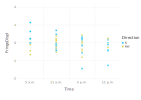

In [5]:
fig = plot(data, x=:Time, y=:FringeDispl, color=:Direction, Geom.point)
# draw(PDF("illingworth1927.pdf"), fig)

### Sélection des observations effectuées à 5 a.m. dans la direction N (Tableau 5.1 des notes)

In [6]:
df = filter(row -> (row.Time == "5 a.m.") & (row.Direction =="N"), data )

Row,Time,Direction,Weights,FringeDispl,Speed
,String7,String3,Float64,Float64,Float64
1,5 a.m.,N,0.12,0.24,1.7351
2,5 a.m.,N,0.57,1.14,3.78156
3,5 a.m.,N,0.0,0.0,0.0
4,5 a.m.,N,0.1,0.2,1.58392
5,5 a.m.,N,0.32,0.64,2.8334
6,5 a.m.,N,-0.01,-0.02,-0.500879


In [7]:
y = df.FringeDispl
n = length(y)
ȳ = mean(y)

println("Il y a $n observations et le déplacement moyen est de $ȳ.")

Il y a 6 observations et le déplacement moyen est de 0.36666666666666664.


## 5.1 Modèle gaussien

### Estimation classique par maximum de la vraisemblance

On estime le paramètre inconnu $\mu$ de la loi normale par la méthode du maximum de la vraisemblance. On peut par la suite calculer un intervalle de confiance de niveau 95% pour $\mu$. Rappelons que l'on suppose que la variance est connue et est égale à $\sigma^2 = 1.5^2$.

In [8]:
# Estimation ponctuelle
println("μ̂ = ",ȳ)


# Intervalle de confiance à 95 %
σ = 3/2
pd = Normal(ȳ, σ/sqrt(n))
println("Intervalle de confiance à 95% pour μ : ", quantile(pd, [.025, .975]))


μ̂ = 0.36666666666666664
Intervalle de confiance à 95% pour μ : [-0.8335612524221641, 1.5668945857554963]


## 5.2 Estimation bayésienne de μ

On estime le paramètre inconnu $\mu$ de la loi normale par la méthode bayésienne. On suppose que la variance est connue et est égale à $\sigma^2 = 1.5^2$.

On suppose la loi *a priori* suivante :

$$f_\mu(\mu) = \mathcal{N}(\mu \mid 0, \sigma^2)$$

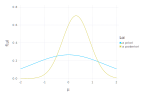

In [9]:
σ = 3/2

# définition de la loi a priori
prior = Normal(0,σ)

# Stockage des densités dans un DataFrame pour un affichage rapide
x = range(-2, stop=2,length=1001)
df = DataFrame(μ = x)
df[!,Symbol("a priori")] = pdf.(prior,x)

# calcul de la loi a posteriori 
posterior = Normal(n/(n+1)*ȳ,σ/sqrt(n+1))
df[!,Symbol("a posteriori")] = pdf.(posterior,x)

df = stack(df, Not(:μ))
rename!(df, :variable => :Loi)

fig = plot(df,x=:μ, y=:value, color=:Loi, Geom.line, Guide.ylabel("f(μ)"))
# draw(PDF("posterior_info.pdf"), fig)

## 5.3 Loi a priori non informative

Utilisons la loi *a priori* non-informative impropre suivante pour $\mu$ :
$$f_\mu(\mu) \propto 1.$$

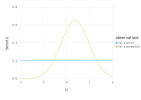

In [10]:

# Stockage des densités dans un DataFrame pour un affichage rapide
df = DataFrame(μ = x)
df[!,Symbol("loi a priori")] .= .2

# calcul de la loi a posteriori
posterior = Normal(ȳ,σ/sqrt(n))
df[!,Symbol("loi a posteriori")] = pdf.(posterior,x)

df = stack(df, Not(:μ))
rename!(df, :value => :densité, :variable => :observations)

fig = plot(df,x=:μ, y=:densité, color=:observations, Geom.line)
# draw(PDF("posterior_noninfo.pdf"), fig)

Comparaison des lois *a posteriori* en fonction du caractère informatif ou non-informatif de la loi *a priori*.

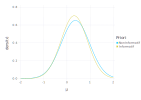

In [11]:
# Stockage des densités dans un DataFrame pour un affichage rapide
df = DataFrame(μ = x)

df[!,:NonInformatif] = pdf.(Normal(ȳ,σ/sqrt(n)), x)
df[!,:Informatif] = pdf.(Normal(n/(n+1)*ȳ,σ/sqrt(n+1)), x)

longdf = stack(df, [:NonInformatif, :Informatif], :μ)
rename!(longdf, :value => :densité, :variable=>:Priori)

fig = plot(longdf, x=:μ, y=:densité, color=:Priori, Geom.line)
# draw(PDF("info_vs_noninfo.pdf"), fig)

## 5.4 Inférence bayésienne


### 5.4.1 Estimation ponctuelle

On utilise la loi *a priori* informative non informative.

In [12]:
# La loi a posteriori
posterior = Normal(ȳ,σ/sqrt(n))

# La moyenne de la loi a posteriori
μ̂ = mean(posterior)
println("La moyenne de la loi a posteriori est égale à ", μ̂)

# Le mode de la loi a posteriori
μ̂ = mode(posterior)
println("Le mode de la loi a posteriori est égale à ", μ̂)

La moyenne de la loi a posteriori est égale à 0.36666666666666664
Le mode de la loi a posteriori est égale à 0.36666666666666664


### 5.4.2 Estimation par intervalle de crédibilité bayésien

Utilisons la loi *a priori* non-informative. Puisque la loi *a posteriori* est symétrique, l'intervalle de crédibilité usuel et l'intervalle de plus haute densité *a posteriori* concordent.

In [13]:
posterior = Normal(ȳ,σ/sqrt(n))

I = quantile.(posterior,[.025 .975])

println("L'intervalle de crédibilité bayésien de niveau 95% pour μ est [$(I[1]) , $(I[2])].")

L'intervalle de crédibilité bayésien de niveau 95% pour μ est [-0.8335612524221641 , 1.5668945857554963].


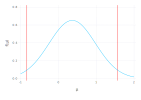

In [14]:
plot( x-> pdf(posterior, x), -1, 2, Guide.xlabel("μ"), Guide.ylabel("f(μ)"),
    xintercept = I, Geom.vline(color="red"))

### 5.2.7 Distribution prédictive

Utilisons la loi *a priori* non-informative.

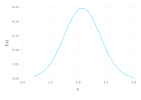

In [15]:
predictive = Normal(ȳ,sqrt( (n+1)/n )*σ )


plot(x -> pdf(predictive, x), -4, 5)


## Quelques figures supplémentaires

Si la loi *a posteriori* était asymétrique

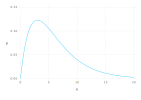

In [16]:
pd = Gamma(2,3)
xx = 0:.1:20
plot(x=xx, y=pdf.(pd,xx), Geom.line)

### Identification de l'intervalle HPD

In [17]:
using Optim

f(x::Array{<:Real}) = abs(cdf(pd, x[2])-cdf(pd, x[1]) -.95)
res = optimize(f,[0.0, 100.0])
ci = Optim.minimizer(res)

2-element Vector{Float64}:
  0.09408004552932887
 14.266740256005173

In [18]:
# Vérification que l'intervalle obtenue est bien de niveau 95%

cdf(pd, ci[2])-cdf(pd, ci[1])

0.9500000000238236

### Traçage des intervalles de crédibilité
- basé sur les quantiles
- basé sur HPD


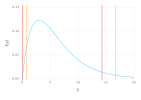

In [19]:
xint = vcat(quantile.(pd, [.025, .975]), ci )

fig = plot(x=xx, y=pdf.(pd,xx), Geom.line, xintercept=xint,
    Guide.xlabel("y"), Guide.ylabel("f(y)"),
    Geom.vline(color=["orange","orange","red","red"]))
# draw(PDF("hpd.pdf"), fig)

In [20]:
fd = Normal(-0.0297, sqrt(65/64)*3/2)


Normal{Float64}(μ=-0.0297, σ=1.511673327805978)

In [21]:
quantile.(fd, [.025, .975])

2-element Vector{Float64}:
 -2.9925252788895356
  2.9331252788895332

In [22]:
mean(fd) + 1.96*std(fd)

2.9331797224997165